# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Xro0QiR.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



# 🤝 BREAKOUT ROOM #1

## Dependencies

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [68]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [69]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"PSI Day7 - AI Bills - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 1: Simple LangGraph RAG

Now that we have our dependencies set-up - let's create a simple RAG graph that works over our Loan PDFs from previous sessions.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [70]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("bills", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

bill_knowledge_resources = directory_loader.load()

Now we can chunk it down to size!

In [71]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

bill_knowledge_chunk = text_splitter.split_documents(bill_knowledge_resources)

Now we've successfully split our single PDF into...

In [72]:
len(bill_knowledge_chunk)

62

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [73]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [74]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=bill_knowledge_chunk,
    embedding=embedding_model,
    location=":memory:"
)

Let's make sure we can access it as a retriever.

In [75]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [76]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [77]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-5-mini")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single graph - and we're off!

In [78]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

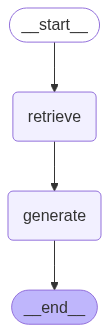

In [79]:
rag_graph

Let's test this out and make sure it works.

In [80]:
import json

result = rag_graph.invoke({"question" : "What is the best approach for AI in education?"})


In [81]:
import json, textwrap, dataclasses
from typing import Any

def pretty_print(
    obj: Any,
    *,
    width: int = 100,          # target wrap width for long strings
    indent: int = 2,           # JSON indent
    sort_keys: bool = False,   # sort dict keys
    max_str: int = 800,        # truncate very long strings
    max_list: int = 200,       # cap huge lists
    wrap_strings: bool = True, # wrap long strings
):
    def is_langchain_doc(o):
        return o.__class__.__name__ == "Document" and hasattr(o, "page_content")

    def to_serializable(o, _depth=0):
        # LangChain Document → compact dict
        if is_langchain_doc(o):
            meta = getattr(o, "metadata", {}) or {}
            # keep only commonly useful metadata keys (expand as needed)
            keep = ["source", "file_path", "page", "title", "author"]
            filtered_meta = {k: meta.get(k) for k in keep if k in meta}
            return {
                "type": "Document",
                "page_content": o.page_content,
                "metadata": filtered_meta or meta,  # fallback to all if nothing matched
            }

        # dataclasses
        if dataclasses.is_dataclass(o):
            return {k: to_serializable(v, _depth+1) for k, v in dataclasses.asdict(o).items()}

        # NumPy / pandas scalars
        try:
            import numpy as np  # optional
            if isinstance(o, (np.generic,)):
                return o.item()
        except Exception:
            pass

        # bytes → hex (short) or utf-8 (best effort)
        if isinstance(o, (bytes, bytearray)):
            try:
                return o.decode("utf-8")
            except Exception:
                return o[:16].hex() + ("…hex" if len(o) > 16 else "")

        # primitives
        if isinstance(o, (str, int, float, bool)) or o is None:
            return o

        # dicts
        if isinstance(o, dict):
            return {str(k): to_serializable(v, _depth+1) for k, v in o.items()}

        # lists / tuples / sets
        if isinstance(o, (list, tuple, set)):
            seq = list(o)
            if len(seq) > max_list:
                seq = seq[:max_list] + [f"…({len(o)-max_list} more)"]
            return [to_serializable(v, _depth+1) for v in seq]

        # fallback: try __dict__, else string repr
        return to_serializable(getattr(o, "__dict__", str(o)), _depth+1)

    def transform_strings(x):
        # truncate + wrap strings inside the structure
        if isinstance(x, str):
            s = x if max_str is None or len(x) <= max_str else (x[:max_str] + "…")
            if wrap_strings and width:
                s = "\n".join(textwrap.wrap(s, width=width)) if "\n" not in s else \
                    "\n".join("\n".join(textwrap.wrap(line, width=width)) for line in s.splitlines())
            return s
        if isinstance(x, list):
            return [transform_strings(v) for v in x]
        if isinstance(x, dict):
            return {k: transform_strings(v) for k, v in x.items()}
        return x

    normalized = to_serializable(obj)
    normalized = transform_strings(normalized)
    print(json.dumps(normalized, indent=indent, ensure_ascii=False, sort_keys=sort_keys))

In [82]:
pretty_print(result, width=100, max_str=1200, sort_keys=True)

{
  "context": [
    {
      "metadata": {
        "author": "",
        "file_path": "bills\\HB02186.pdf",
        "page": 3,
        "source": "bills\\HB02186.pdf",
        "title": "House Bill on Integrating AI in Basic Education Curriculum (BHPL).docx"
      },
      "page_content": "C.​\nTo foster creativity, problem-solving, and critical thinking skills among students\nthrough exposure to AI tools and projects;\n\nD.​\nTo promote inclusive access to AI education, especially in public schools and\nunderserved communities; and\n\nE.​\nTo establish partnerships with academic institutions, industry, and international\norganizations to enhance curriculum content and teacher training.\n\nSEC. 4. SCOPE AND COVERAGE.\n\nThe integration of AI education shall cover all public and private elementary and\nsecondary schools nationwide. The curriculum shall be age-appropriate and\ncontextualized to different grade levels and learner capacities.\n\nSEC. 5. CURRICULUM DEVELOPMENT.\n\nThe Departm

In [83]:
from IPython.display import Markdown, display

display(Markdown(result["response"]))

Based on the provided bill, the best approach is a comprehensive, phased, and inclusive integration of AI into basic education that includes:

- Formal K–12 integration with age-appropriate content: introduce AI awareness and digital literacy in Grades 1–3 and basic-to-intermediate AI modules for Grades 4–12.  
- Curriculum and materials development: DepEd (with DOST, DICT, CHED, and stakeholders) to produce curriculum guides, lesson plans, teaching strategies and learning resources (to be completed within two years).  
- Ethics and responsible use: embed modules on data privacy, responsible data use, algorithmic fairness, and societal impacts.  
- Pilot testing and feedback: pilot the curriculum in selected schools and refine materials based on teacher, student, and parent feedback.  
- Teacher capacity-building: continuous professional development covering AI concepts, programming fundamentals, pedagogy, certification programs, and provision of teaching resources and technical support.  
- Infrastructure and resources: ensure computers, internet, software, an open-access online repository of AI materials, and technical assistance for resource-limited schools.  
- Partnerships and support: authorize memoranda of agreement with academia, industry, international organizations, and professional bodies to support curriculum enhancement, training, competitions, and donations.  
- Continuous review and updating: regularly revise curriculum and materials to keep pace with technological advances.  
- Emphasis on inclusivity: cover all public and private schools nationwide and prioritize underserved communities.

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

##### 🏗️ Activity #1

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

</div>

In [137]:
# Dynamic Arxiv Paper Fetching Implementation
import arxiv
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_core.tools import tool
from typing import Annotated, List, Optional
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Qdrant
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import tiktoken

# Enhanced Arxiv Tools
@tool
def search_and_fetch_arxiv_papers(
    query: Annotated[str, "Search query to find relevant Arxiv papers"],
    max_results: Annotated[int, "Maximum number of papers to fetch"] = 5,
    sort_by: Annotated[str, "Sort by: relevance, lastUpdatedDate, submittedDate"] = "relevance"
) -> str:
    """Search Arxiv for papers matching the query and return their content for RAG processing."""
    
    # Search Arxiv
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance if sort_by == "relevance" else arxiv.SortCriterion.LastUpdatedDate
    )
    
    papers_content = []
    for result in search.results():
        paper_info = f"""
Title: {result.title}
Authors: {', '.join([author.name for author in result.authors])}
Abstract: {result.summary}
Published: {result.published}
URL: {result.entry_id}
"""
        papers_content.append(paper_info)
    
    return "\n\n".join(papers_content)

@tool
def fetch_specific_arxiv_paper(
    paper_id: Annotated[str, "Arxiv paper ID (e.g., '2308.08155') or full URL"]
) -> str:
    """Fetch a specific Arxiv paper by ID and return its content."""
    
    # Clean paper ID
    if "arxiv.org" in paper_id:
        paper_id = paper_id.split("/")[-1]
    
    search = arxiv.Search(id_list=[paper_id])
    result = next(arxiv.Client.results())
    
    return f"""
Title: {result.title}
Authors: {', '.join([author.name for author in result.authors])}
Abstract: {result.summary}
Published: {result.published}
URL: {result.entry_id}
Full Text: {result.summary}
"""

# Dynamic RAG Pipeline
class DynamicArxivRAG:
    def __init__(self):
        self.embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=750,
            chunk_overlap=0,
            length_function=self._tiktoken_len,
        )
        self.vectorstore = None
    
    def _tiktoken_len(self, text):
        tokens = tiktoken.encoding_for_model("gpt-4o").encode(text)
        return len(tokens)
    
    def process_arxiv_content(self, arxiv_content: str) -> List[Document]:
        """Process Arxiv content into documents for vector storage."""
        documents = []
        papers = arxiv_content.split("\n\n")
        
        for paper in papers:
            if paper.strip():
                doc = Document(
                    page_content=paper,
                    metadata={
                        "source": "arxiv",
                        "type": "research_paper"
                    }
                )
                documents.append(doc)
        
        chunked_docs = self.text_splitter.split_documents(documents)
        return chunked_docs
    
    def create_vectorstore(self, arxiv_content: str):
        """Create vector store from Arxiv content."""
        chunked_docs = self.process_arxiv_content(arxiv_content)
        
        self.vectorstore = Qdrant.from_documents(
            documents=chunked_docs,
            embedding=self.embedding_model,
            location=":memory:"
        )
        
        return self.vectorstore.as_retriever()
    
    def update_vectorstore(self, arxiv_content: str):
        """Update existing vector store with new Arxiv content."""
        chunked_docs = self.process_arxiv_content(arxiv_content)
        
        if self.vectorstore is None:
            return self.create_vectorstore(arxiv_content)
        else:
            self.vectorstore.add_documents(chunked_docs)
            return self.vectorstore.as_retriever()

# Initialize dynamic RAG
dynamic_rag = DynamicArxivRAG()

@tool
def load_arxiv_papers_for_topic(
    topic: Annotated[str, "Topic to search for Arxiv papers"],
    max_papers: Annotated[int, "Maximum number of papers to load"] = 10
) -> str:
    """Load Arxiv papers for a specific topic and prepare them for RAG queries."""
    
    # Search and fetch papers
    arxiv_content = search_and_fetch_arxiv_papers.invoke({
        "query": topic,
        "max_results": max_papers
    })
    
    # Create vector store
    retriever = dynamic_rag.create_vectorstore(arxiv_content)
    
    return f"Successfully loaded {max_papers} Arxiv papers on '{topic}' and prepared them for RAG queries."

@tool
def retrieve_dynamic_arxiv_information(
    query: Annotated[str, "Query to search for in the dynamically loaded Arxiv papers"]
) -> str:
    """Use Retrieval Augmented Generation to retrieve information from dynamically loaded Arxiv papers."""
    
    if dynamic_rag.vectorstore is None:
        return "No Arxiv papers have been loaded yet. Please use load_arxiv_papers_for_topic first."
    
    retriever = dynamic_rag.vectorstore.as_retriever()
    retrieved_docs = retriever.invoke(query)
    
    # Create RAG response
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])
    
    rag_prompt = ChatPromptTemplate.from_messages([
        ("human", """
Use the provided context from Arxiv papers to answer the query. 
Only use the provided context. If the answer is not in the context, say "I don't have enough information from the loaded papers."

Context:
{context}

Query: {query}
""")
    ])
    
    rag_chain = rag_prompt | openai_chat_model | StrOutputParser()
    return rag_chain.invoke({"context": context, "query": query})

# Update research team tools
research_team_tools = [
    tavily_tool,
    search_and_fetch_arxiv_papers,
    fetch_specific_arxiv_paper,
    load_arxiv_papers_for_topic,
    retrieve_dynamic_arxiv_information
]

## Task 2: Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [94]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph
from langgraph.constants import END

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [95]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [96]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [97]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Task 3: Research Team - A LangGraph for Researching on AI Proposed Bills

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic, in this case: Loans!

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [98]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [99]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the AI bills proposed in the Philippines."""
  return rag_graph.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [100]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-5o-mini` today. This LLM is going to be doing a lot of reasoning - but we also want to keep our costs down, so we'll use a lightweight; but powerful, model!

In [101]:
llm = ChatOpenAI(model="gpt-4o-mini")

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

</div>

### Answer:
1) Why is a “powerful” LLM important for this use-case?

    - It must plan, route, and synthesize — not just answer one-off questions.

    - Handles long context and keeps outputs on-schema (tools/functions, ReportData).

    - Reduces misrouting, hallucinations, and “stuck in a loop” behavior.

2) What tasks make reasoning a potential limiter?

    - Plan & decompose the query into sub-tasks.

    - Route to the right agent/tool (supervisor decisions).

    - Synthesize multiple retrieved chunks/search results coherently.

    - Follow structure strictly (function calls, structured outputs).

    - Control loops (helpfulness checks, stop/continue).

    - Maintain context across multi-step, multi-agent messages.

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4o Mini model, and then create its node - and name it `Search`.

In [102]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for latest info using the tavily search engine. Do not use on AI bills.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [ ]:
# research_agent = create_agent(
#     llm,
#     [retrieve_information],
#     "You are a research assistant who can provide information on the AI bills proposed in the Philippines.",
# )
# research_node = functools.partial(agent_node, agent=research_agent, name="BillRetriever")

In [103]:
research_agent = create_agent(
    llm,
    research_team_tools,
    """You are a research assistant who can:
    1. Search for latest information using Tavily
    2. Search and fetch Arxiv papers on any topic
    3. Load specific Arxiv papers by ID
    4. Load Arxiv papers for specific topics and prepare them for RAG queries
    5. Retrieve information from loaded Arxiv papers using RAG
    6. Provide information on AI bills proposed in the Philippines
    
    When researching AI topics, prefer using Arxiv papers for technical accuracy.
    Always load relevant papers before attempting to answer technical questions.
    """,
)
research_node = functools.partial(agent_node, agent=research_agent, name="BillRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [ ]:
# supervisor_agent = create_team_supervisor(
#     llm,
#     ("You are a supervisor tasked with managing a conversation between the"
#     " following workers:  Search, BillRetriever. Given the following user request,"
#     " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
#     " task and respond with their results and status. "
#     " You should never ask your team to do anything beyond research. They are not required to write content or posts."
#     " You should only pass tasks to workers that are specifically research focused."
#     " When finished, respond with FINISH."),
#     ["Search", "BillRetriever"],
# )

/var/folders/r9/vmqskzn976z46cchxvqpz49c0000gn/T/ipykernel_68492/488856706.py:34: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [104]:
supervisor_agent = create_team_supervisor(
    llm,
    ("""You are a supervisor managing a research team with the following capabilities:
    - Search: Use Tavily for general web search and latest information
    - BillRetriever: Access Philippine AI bill information AND dynamic Arxiv paper research
    
    For technical AI questions (LLMs, fine-tuning, architectures, etc.), the BillRetriever should:
    1. First load relevant Arxiv papers using load_arxiv_papers_for_topic
    2. Then retrieve specific information using retrieve_dynamic_arxiv_information
    
    For policy/bill questions about Philippine AI legislation, use BillRetriever to access the hardcoded bill documents.
    
    For general information not covered by bills or technical papers, use Search.
    
    Always ensure relevant papers are loaded before attempting detailed technical answers.
    """),
    ["Search", "BillRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [107]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("BillRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [108]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("BillRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "BillRetriever": "BillRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [109]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

#### Display Graph

In [110]:
import nest_asyncio
nest_asyncio.apply()

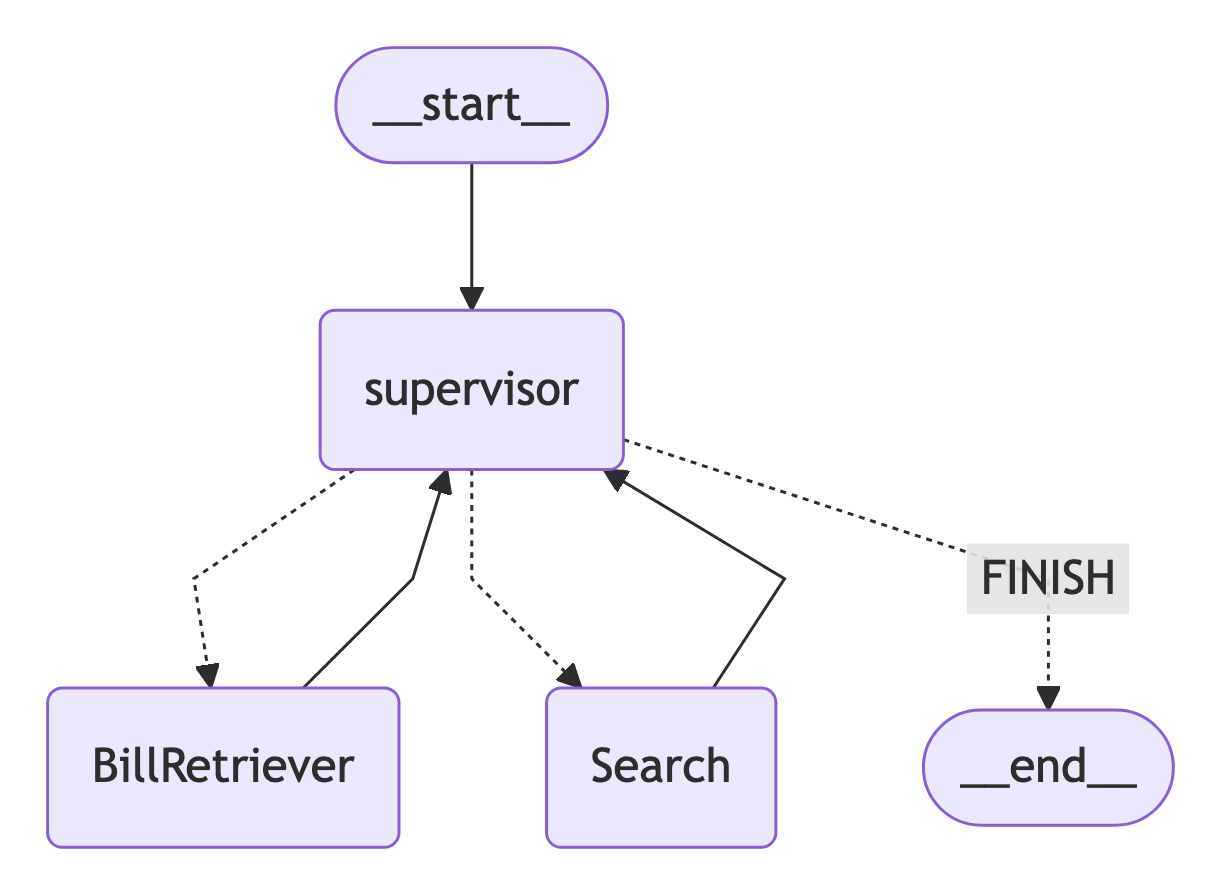

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

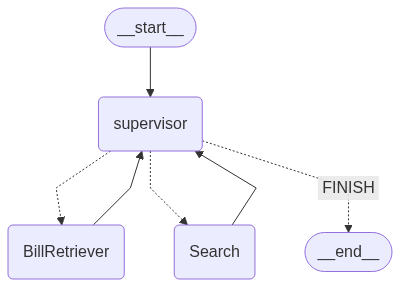

In [111]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.API, # changed value from Pyppeteer into API
            background_color="white",
            padding=10,
        )
    )
)

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [112]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

Now, finally, we can take it for a spin!

In [113]:
for s in research_chain.stream(
    "What is the maximum penalty for the violation of the AI bill?", {"recursion_limit": 10}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'BillRetriever'}}
---
{'BillRetriever': {'messages': [HumanMessage(content='The proposed AI bill in the Philippines outlines various penalties for violations, with the maximum penalties as follows:\n\n1. Fines for passing off AI-generated content as human-made can range from **₱500,000 to ₱2,000,000** or imprisonment for **six months to three years**, or both.\n\n2. For intentionally using AI systems to commit fraud or facilitate crimes, fines can range from **₱2,000,000 to ₱10,000,000**, or imprisonment for **six to 12 years**, or both.\n\n3. If the offense results in death, physical injury, or large-scale damage, the penalties will be at their maximum limits.\n\n4. For spreading disinformation or using AI for mass opinion manipulation, penalties include fines between **₱1,000,000 and ₱5,000,000** or imprisonment for **three to 10 years**, or both.\n\nIn summary, the maximum penalty for severe violations may reach up to **₱10 million** in fines or imprisonment 

In [117]:
for s in research_chain.stream(
    "In Philippines, what is the maximum penalty for the violation of the AI bill?", {"recursion_limit": 10}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'BillRetriever'}}
---
{'BillRetriever': {'messages': [HumanMessage(content='In the Philippines, the maximum penalties for violations of the proposed AI bills include:\n\n1. **General Non-Compliance**: A fine ranging from **P500,000 to P5,000,000**, or imprisonment from **six months to three years**, or both at the discretion of the court.\n   \n2. **Intentional Misuse**: If AI systems are used to commit fraud, facilitate or conceal crimes, or cause harm to life, liberty, property, or national security, penalties include a fine of **P2,000,000 to P10,000,000**, or imprisonment of **six to 12 years**, or both.\n\n3. **Severe Consequences**: If an offense results in death, physical injury, or significant financial/reputational damage, the maximum penalties will apply.\n\n4. **Disinformation and Manipulation**: Using AI to create or disseminate disinformation, conduct mass opinion manipulation (through bots or deepfakes), or unauthorized surveillance can incur penal

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Question: Why Search?!?!

The supervisor seems to prefer Search. 
How can you improve the system to prioritize billretriever?

</div>

### Answer:

Why Search?
- The supervisor is defaulting to Search because it has no hard rule that “penalties about PH AI bills → BillRetriever first,” and Search tends to produce a confident-looking answer quickly, so the supervisor stops.

How to improve the system to prioritize BillRetriever?
- Supervisor rule: If the query mentions Philippines/PH/House Bill/HB/violations/penalties → choose BillRetriever first; use Search only if BillRetriever says it lacks coverage.

- Tool roles: Describe BillRetriever as the PH AI-bill expert (penalties, sections, citations). Describe Search as general/news fallback not for AI bills.

- Evidence preference: Tell the supervisor to prefer answers with bill sections/citations; if missing, route to BillRetriever.

- Self-reporting: Have agents label replies COVERAGE: HIGH/LOW; on LOW, the supervisor re-routes to BillRetriever.

- Keyword bias: Add a simple keyword check (e.g., “Philippines”, “HB”, “penalty”) to bias initial routing toward BillRetriever.

- Finish rule: For PH-bill questions, don’t finish until BillRetriever has responded at least once.


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

Hint: try asking Cursor agent to draw diagram using mermaid... sometimes you can get lucky.
</div>

Mermaid Diagram

![Diagram](images/diagram.png)

<div style="background-color:teal; color: black; padding: 10px; border-radius: 5px;">

### BREAK-OUT #2

</div>

## Task 4: Document Writing Team - A LangGraph for  Planning, Writing, and Editing Response.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for Reviewing, Planning, Writing Response!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [118]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

### Previous Complaint Data
@tool 
def reference_previous_responses(
    query: Annotated[str, "The query to search for in the previous responses."],
) -> Annotated[str, "The previous responses that match the query."]:
    """Search for previous responses that match the query."""
    return qdrant_complaint_retriever.invoke(query)


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

</div>

### Answer:

create_outline(points, file_name) — writes a numbered outline (your points) to a file in the working folder and returns a confirmation path.

read_document(file_name, start=None, end=None) — reads a text file and returns the lines (optionally a slice).
Note: current code forces start=0 anytime start is provided.

write_document(content, file_name) — saves the given text into a new/overwritten file and returns where it was saved.

reference_previous_responses(query) — searches your prior responses via the retriever and returns the most relevant snippets.

edit_document(file_name, inserts={line_num: text, ...}) — inserts text at specific (1-indexed) line numbers, then saves the edited file.

Working dir setup — a random subfolder under ./content/data is created so each run writes to its own safe place.

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [119]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [120]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [121]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing responses to bill proposals.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document, reference_previous_responses],
    ("You are an expert senior researcher tasked with writing a laws and bills and"
    " taking notes to craft a response.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

empathy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in empathy, compassion, and understanding - you edit the document to make sure it's empathetic and compassionate."
    "Below are files currently in your directory:\n{current_files}"),
)
empathy_editor_agent = prelude | empathy_editor_agent
empathy_node = functools.partial(
    agent_node, agent=empathy_editor_agent, name="EmpathyEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "EmpathyEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [122]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("EmpathyEditor", empathy_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("EmpathyEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "EmpathyEditor" : "EmpathyEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
compiled_authoring_graph = authoring_graph.compile()

#### Display Graph

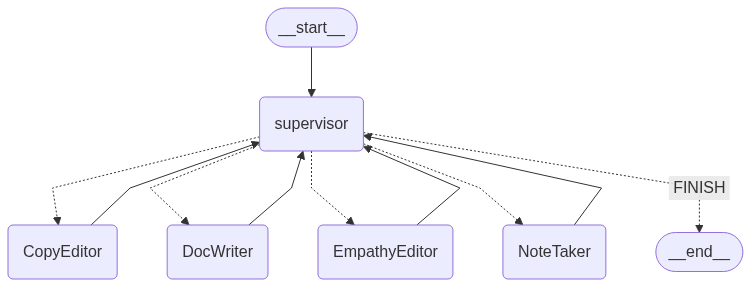

In [124]:
from IPython.display import Image, display

display(
    Image(
        compiled_authoring_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.API,
            background_color="white",
            padding=10,
        )
    )
)

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [125]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [126]:
for s in authoring_chain.stream(
    "Write a response on the position of AI bills in Philippines and how it can affect the research and development of AI in the country.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The response regarding the position of AI bills in the Philippines and their impact on research and development has been successfully drafted and saved as a document. If you need any further modifications or additional information, feel free to let me know!', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content="Here is the response regarding the position of AI bills in the Philippines and their impact on research and development:\n\n---\n\n**Response on the Position of AI Bills in the Philippines and Their Impact on AI Research and Development**\n\nThe introduction of artificial intelligence (AI) bills in the Philippines marks a significant step towards establishing a regulatory framework that could guide the responsible development and implementation of AI technologies in the country. As 

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [127]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "Response team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [128]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [129]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Response team", get_last_message | authoring_chain | join_graph)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [130]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("Response team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Response team": "Response team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
compiled_super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [138]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a statement on the positioning of AI bills in Philippines as it relates to impact of penalties and listing of directories to AI research anddevelopment in the country. Is it feasible to implement a directory of all AI applications or will it slow down progress? Conduct research against global AI bills and how other countries are handling AI bills. Then make sure you consult the response team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content="**Statement on the Positioning of AI Bills in the Philippines: Impact of Penalties and the Feasibility of an AI Applications Directory**\n\nThe Republic of the Philippines is witnessing a surge in legislative efforts to regulate artificial intelligence (AI) technologies, highlighted by multiple bills aimed at ensuring ethical development and deployment. Notably, Senator Pia Cayetano's proposed bill establishes significant penalties for unethical AI conduct, ranging from fines of Php 500,000 to Php 10 million and imprisonment for various terms depending on the severity of the violation, including disseminating disinformation and deploying unregistered AI systems.\n\nA key aspect of these legislative initiatives is the creation of regulatory frameworks that would mandate the registration of AI systems and the maintenance of a comprehensive directory of AI applications and developers. While

## SAMPLE POST!

The regulatory landscape for artificial intelligence (AI) in the Philippines is undergoing significant evolution through the introduction of several bills designed to manage the development and implementation of AI technologies. These proposed legislations highlight the government’s awareness of AI's potential to profoundly enhance various sectors, including public services, disaster resilience, agriculture, education, and healthcare.  

For AI developers, these bills offer a framework that aims to balance technological innovation with ethical considerations and public safety. The regulations stress the importance of transparency, accountability, and human oversight in AI development, serving as safeguards against inherent risks such as algorithmic bias and misinformation. Notably, the legislation draws inspiration from global standards, such as the European Union's AI Act, advocating for a regulatory approach that promotes responsible AI innovation without hindering creativity and progress.  

Moreover, the bills establish the state as a protector of citizens' rights, ensuring that AI is developed and utilized in ways that minimize harm and prevent abuse. By setting forth these guidelines, the legislation aspires to cultivate an environment that supports the creativity and ingenuity of Filipino developers while aligning with global best practices.  

In conclusion, the proposed AI bills in the Philippines represent a commitment to fostering a responsible, ethical, and forward-thinking approach to artificial intelligence. This dual focus on innovation and regulation is vital for encouraging development while safeguarding the well-being of the population and society as a whole.